#  05-FAQRAGSystem

- Author: [Taylor(Jihyun Kim)](https://github.com/Taylor0819)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/03-GraphDB/05-FAQRAGSystem.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/9-Cookbook/03-GraphDB/05-FAQRAGSystem.ipynb)

## Overview
In this tutorial, you’ll learn how to build a `Neo4j` graph using the Titanic dataset and run Cypher queries through the LangChain library. Aimed at beginners, it covers:

- Data Loading & Preprocessing: Convert the Titanic CSV to a Pandas DataFrame, handle missing values, and prepare fields for graph modeling.
- Graph Modeling in Neo4j: Create passenger nodes and relationships (e.g., SAME_TICKET) to represent key Titanic connections.
- Running Cypher Queries: Retrieve passenger info, filter by class or survival, and calculate statistics.


### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Load Titanic data](#load-titanic-data)
- [Consider the Data with Arrows.app](#consider-the-data-with-arrows.app)
- [Data Restructure](#data-preprocessing)
- [Neo4j Database Connection](#neo4j-database-connection)
- [Usage Example](usage-example)


### References

- [LangChain Neo4j](https://python.langchain.com/docs/integrations/graphs/neo4j_cypher)
- [Neo4j Arrows](https://neo4j.com/labs/arrows)
----

## Environment Setup
Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]** 

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [278]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [279]:
# Install required packages
from langchain_opentutorial import package

package.install(
    ["langsmith", "langchain_neo4j", "langchain_openai", "langgraph"],
    verbose=False,
    upgrade=False,
)

In [280]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "05-FAQRAGSystem",
        "NEO4J_URI": "",
        "NEO4J_USERNAME": "",
        "NEO4J_PASSWORD": "",
    }
)

Environment variables have been set successfully.


In [281]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [282]:
import os
import nest_asyncio

# Allow async
nest_asyncio.apply()

## Load Titanic Data

### Data Preparation

In this tutorial, we will use the following csv file:

- Download Link: [Kaggle Titanic Dataset](https://www.kaggle.com/datasets/brendan45774/test-file/data)
- Author : brendan45774 (kaggle ID)
- File name: "tested.csv"
- File path: "../data/tested.csv"

There are two ways to obtain the dataset:

1. Download directly from the Kaggle link above
2. Use the Python code below to automatically download via Kaggle API

In [283]:
# Download and save sample CSV file to ./data directory
import requests
import zipfile


def download_csv(url, zip_path, extract_dir):
    """
    Downloads a CSV file from the given URL and saves it to the specified path.

        Args:
        url (str): The URL of the CSV file to download
        zip_path (str): The full path (including file name) where the zip file will be temporarily saved
        extract_dir (str): The directory path where the contents will be extracted
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(zip_path), exist_ok=True)

        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the file to the specified path
        with open(zip_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        # Extract the zip file
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_dir)

        print(f"File downloaded and extracted to {extract_dir}")

        # Delete the temporary zip file (optional)
        os.remove(zip_path)
        print(f"Temporary zip file deleted: {zip_path}")

    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"CSV downloaded and saved to: {zip_path}")


# Configuration for the PDF file
url = "https://www.kaggle.com/api/v1/datasets/download/yasserh/titanic-dataset"
zip_path = "../data/data.zip"
extract_dir = "../data"

# Download the PDF
download_csv(url, zip_path, extract_dir)

File downloaded and extracted to ../data
Temporary zip file deleted: ../data/data.zip


In [284]:
import pandas as pd

file_path = "./data/Titanic-Dataset.csv"

# Read Titanic.csv file
df = pd.read_csv("../data/Titanic-Dataset.csv")

# This includes checking data structure, sample data
print("=== DataFrame Info ===")
df.info()

print("=== Sample data ===")
df.head()

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
=== Sample data ===


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Column Descriptions
Key column descriptions:
- `PassengerId` : Unique identifier for each passenger
- `Survived` : Survival status (0 = No, 1 = Yes)
- `Pclass` : Ticket class (1, 2, 3)
- `Name` : Passenger name
- `Sex` : Gender
- `Age` : Age in years
- `SibSp` : Number of siblings/spouses aboard
- `Parch` : Number of parents/children aboard
- `Ticket` : Ticket number
- `Fare` : Passenger fare
- `Cabin` : Cabin number
- `Embarked` : Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Consider the data with Arrows.app
When converting a complete tabular dataset like a passenger manifest into a graph, it may seem simple to create nodes for person, tickets, and departure points while turning the remaining columns into properties. 

However, the flexibility of the graph structure requires careful consideration of how to categorize data into nodes, relationships, or properties. The way the data is structured may vary depending on the types of queries you plan to run on the graph.

To assist with this, Neo4j provides `Arrows.app`, a tool that allows you to visualize relationships across the graph before uploading any specific data. With [arrows.app](https://arrows.app), you can explore and experiment with different ways to model the data. To demonstrate this, I will present an example graph that represents a complex data structure.

### Defining the Relationship Categories
The first step was to define the categories of relationships we were interested in.
Here are the three relationships I had to define: MARRIED_TO, SIBLING_TO, PARENT_OF.
![explanation-01](../assets/05-faqragsystem-flow-explanation-01.png)


Both MARRIED_TO and SIBLING_TO would imply the same relationship in the other direction between the same nodes. 

PARENT_OF would imply a reverse relationship of CHILD_OF.

## Simple Data Preprocessing
- Creating `LastName` Column: Extracts the last name from the Name column and stores it in a new column LastName. The extraction is done by splitting the string at the comma and using the first element.
- Removing Missing Values: Drops rows where the `Age` column has null values to ensure data completeness.
- Data Type Conversion: Converts the `Ticket` column to string format to maintain consistency in data types.

In [285]:
# Optional: parse last names from "Name" if helpful
df["LastName"] = df["Name"].apply(lambda x: x.split(",")[0].strip())

# Drop rows where Age is null
df.dropna(subset=["Age"], inplace=True)

# Convert "Ticket" to a string type to maintain consistency
df["Ticket"] = df["Ticket"].astype(str)

In [286]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen


# Neo4j Database Connection
First, install the Neo4j graph database. This tutorial is based on Neo4j Desktop .

[Neo4j Desktop Installation link](https://neo4j.com/docs/operations-manual/current/installation/)

[Note] 
You can set up Neo4j in several ways 

1. [`Neo4j Desktop`](https://neo4j.com/docs/operations-manual/current/installation/) :  A desktop application for local development

2. [`Neo4j Sandbox` ](https://neo4j.com/sandbox/) : A free, cloud-based platform for working with graph databases

3. [`Docker` ](https://neo4j.com/docs/operations-manual/current/docker/) : Run Neo4j in a container using the official Neo4j Docker image

**[Important]** Before importing the CSV file, please complete the following setup: 
1. Setup APOC Plugin
2. Update the neo4j.conf file.

For detailed setup instructions, please refer to:

[03-GraphDB/04-MovieQASystem](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/9-Cookbook/03-GraphDB/04-MovieQASystem.ipynb)

### Define Neo4j Credentials

Next, you need to define your Neo4j credentials. If you haven't done this in the previous steps, you can define them using the os package.

[Note] This is not necessary if you've already set the required Neo4j credentials in previous steps.

The default user account information:

Default username: `neo4j`

Default password: `neo4j`

You are required to change the password upon your first login.



In [287]:
import os

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "taylor"
os.environ["NEO4J_PASSWORD"] = "titanic12"

### Import Titanic data
[how to import csv file](https://neo4j.com/docs/getting-started/appendix/tutorials/guide-import-desktop-csv/#csv-location)

We will import a CSV file into the Neo4j Desktop by adding it to the `import` folder.

You can open a finder window by hovering over the three dots to the right side of the started DBMS and select Open folder, then Import
![explanation-02](../assets/05-faqragsystem-flow-explanation-02.png)

You can directly drag & drop files into this folder to add them
![explanation-03](../assets/05-faqragsystem-flow-explanation-03.png)


Let's verify the data import using Neo4j Browser
![explanation-04](../assets/05-faqragsystem-flow-explanation-04.png)

We will use a simple Cypher query to verify that the data has been successfully added:

This query will count the number of rows in the tested.csv file and return the total count. If the data is accessible and correctly loaded, you will see the total row count in the result.

`LOAD CSV FROM 'file:///tested.csv' AS row
RETURN count(row);`

![explanation-05](../assets/05-faqragsystem-flow-explanation-05.png)
![explanation-06](../assets/05-faqragsystem-flow-explanation-06.png)

It has been successfully loaded!


In [288]:
# Neo4j 그래프 연결 시도
from langchain_neo4j import Neo4jGraph

uri = os.environ["NEO4J_URI"]
username = os.environ["NEO4J_USERNAME"]
password = os.environ["NEO4J_PASSWORD"]

try:
    graph = Neo4jGraph(
        url=uri, username=username, password=password, enhanced_schema=True
    )
    print("Neo4j 연결 성공!")
except Exception as e:
    print(f"연결 오류: {str(e)}")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Neo4j 연결 성공!


### Why We Create Passenger Nodes

We create Passenger nodes to represent each Titanic passenger in the graph database. This enables us to:
- Assign properties (e.g., age, ticket, survived) directly to a node.
- Connect these person with relationships to other entities (e.g., SIBLING_OF, MARRIED_TO, PARENT_OF) once we identify family links or other relevant data points.
- Query the graph to analyze connections, run aggregations on survivor counts, family group structures, or other correlations inherent in the Titanic dataset.

By modeling person as nodes, Neo4j can leverage its graph capabilities (like path finding, pattern matching, or graph algorithms) to deliver deeper insights than a traditional relational or tabular approach might.

In [289]:
cypher = """
UNWIND $person AS row
MERGE (p:Passenger { passengerId: toInteger(row.PassengerId) })
ON CREATE SET
    p.name      = row.Name,
    p.lastName  = row.LastName,
    p.age       = CASE WHEN row.Age <> '' THEN toFloat(row.Age) ELSE null END,
    p.sex       = row.Sex,
    p.survived  = row.Survived,
    p.sibsp     = CASE WHEN row.SibSp <> '' THEN toInteger(row.SibSp) ELSE 0 END,
    p.parch     = CASE WHEN row.Parch <> '' THEN toInteger(row.Parch) ELSE 0 END,
    p.family    = CASE
                     WHEN row.SibSp <> '' AND row.Parch <> ''
                     THEN toInteger(row.SibSp) + toInteger(row.Parch)
                     ELSE 0
                  END,
    p.ticket    = row.Ticket,
    p.pclass    = CASE WHEN row.Pclass <> '' THEN toInteger(row.Pclass) ELSE null END,
    p.fare      = CASE WHEN row.Fare <> '' THEN toFloat(row.Fare) ELSE null END,
    p.embarked  = row.Embarked
RETURN count(*) AS total
"""

params = {"person": df.to_dict("records")}

graph.query(cypher, params)

# 확인 쿼리 (Python에서)
result = graph.query("MATCH (t:Ticket) RETURN count(t) AS ticketCount")
print("Ticket node count:", result)

graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Ticket node count: [{'ticketCount': 0}]
Node properties:
- **Passenger**
  - `name`: STRING Example: "Badt, Mr. Mohamed"
  - `lastName`: STRING Example: "Badt"
  - `age`: FLOAT Min: 0.42, Max: 80.0
  - `sex`: STRING Available options: ['male', 'female']
  - `survived`: INTEGER Min: 0, Max: 1
  - `sibsp`: INTEGER Min: 0, Max: 5
  - `parch`: INTEGER Min: 0, Max: 6
  - `ticket`: STRING Example: "2623"
  - `pclass`: INTEGER Min: 1, Max: 3
  - `fare`: FLOAT Min: 0.0, Max: 512.3292
  - `embarked`: STRING Available options: ['C', 'S', 'Q', 'NaN']
  - `family`: INTEGER Min: 0, Max: 7
  - `passengerId`: INTEGER Min: 1, Max: 891
Relationship properties:

The relationships:



Verifying Nodes in Neo4j Browser

Cypher query:
MATCH (n:Passenger) RETURN n LIMIT 10
![explanation-07](../assets/05-faqragsystem-flow-explanation-07.png)
The nodes have been successfully created!

In [290]:
ticket_node_query = """
UNWIND $person AS row
MERGE (t:Ticket {ticketNo: row.Ticket})
"""
params = {"person": df.to_dict("records")}

# 실제 실행
graph.query(ticket_node_query, params)

# 확인 쿼리 (Python에서)
result = graph.query("MATCH (t:Ticket) RETURN count(t) AS ticketCount")
print("Ticket node count:", result)

Ticket node count: [{'ticketCount': 542}]


In [291]:
travel_on_query = """
UNWIND $person AS row
MATCH (p:Passenger { passengerId: toInteger(row.PassengerId) })
MATCH (t:Ticket { ticketNo: row.Ticket })
MERGE (p)-[:TRAVELED_ON]->(t)
RETURN count(*) AS totalEdges
"""
# 실행
rel_result = graph.query(travel_on_query, params)
print("TRAVELED_ON relationships created:", rel_result)

TRAVELED_ON relationships created: [{'totalEdges': 714}]


In [292]:
graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Passenger**
  - `name`: STRING Example: "Badt, Mr. Mohamed"
  - `lastName`: STRING Example: "Badt"
  - `age`: FLOAT Min: 0.42, Max: 80.0
  - `sex`: STRING Available options: ['male', 'female']
  - `survived`: INTEGER Min: 0, Max: 1
  - `sibsp`: INTEGER Min: 0, Max: 5
  - `parch`: INTEGER Min: 0, Max: 6
  - `ticket`: STRING Example: "2623"
  - `pclass`: INTEGER Min: 1, Max: 3
  - `fare`: FLOAT Min: 0.0, Max: 512.3292
  - `embarked`: STRING Available options: ['C', 'S', 'Q', 'NaN']
  - `family`: INTEGER Min: 0, Max: 7
  - `passengerId`: INTEGER Min: 1, Max: 891
- **Ticket**
  - `ticketNo`: STRING Example: "A/5 21171"
Relationship properties:

The relationships:
(:Passenger)-[:TRAVELED_ON]->(:Ticket)


### Why Create These Relationships?

1.	`MARRIED_TO` 
Infers a couple is married if they share the same Ticket, have the same LastName, have sibsp = 1 (i.e., exactly one sibling/spouse count in the data), differ in sex, and a few additional age-based checks.

2.	`SIBLING_OF` 
Among those not married, uses SibSp, LastName, Ticket, and other constraints (e.g., (p2).parch = 1 or 2) to guess they’re siblings if they appear to have the same “family” context but are not recognized as spouses.

3. `PARENT_OF` (and/or `CHILD_OF` )
If the passenger has parch >= 1 (parents/children on board), is older than some threshold, or specifically older than the potential child, create PARENT_OF edges.

These queries are heuristics to reconstruct plausible family connections from partial data. They rely on simplified assumptions—such as “If two people share a ticket, they might be family,” “If a passenger’s sibsp=1, that single sibling/spouse is probably a spouse rather than a child,” etc. You can refine or alter the logic to fit your own inference approach.

### Key Idea
< `MARRIED_TO` >
1. Find passengers (person, other) who share the same ticket using the TRAVELED_ON relationship.

2. Create a **family members list** by collecting others (collect(other)) after ORDER BY other.age DESC.

3. Consider familyMembers[0] (the oldest person) as the "spouse candidate" or "family representative".

4. Use FOREACH(... CREATE ...) statement to create relationships only for passengers meeting specific conditions.

5. p2 = familyMembers[0] → "Only consider the oldest (or first) person as a spouse candidate"

6. (size(familyMembers) = 1 OR p1.age > familyMembers[1].age) → Complex conditions like "If there's only one family member, or if p1 is older than the second oldest person..."

If passengers share the same ticket + same family + sibsp=1, they are considered spouses, processing only the first person by family age order as a spouse.


In [293]:
# MARRIED_TO
married_query = """
MATCH (person:Passenger)
WHERE person.age IS NOT NULL
MATCH (person)-[:TRAVELED_ON]->(ticket:Ticket)<-[:TRAVELED_ON]-(other:Passenger)
WHERE other.age IS NOT NULL
  AND person.family = other.family
WITH person, other
ORDER BY other.age DESC
WITH person AS p1, collect(other) AS familyMembers
WITH p1, familyMembers,
     [p2 IN familyMembers
        WHERE p1.sibsp = 1
          AND p2.sibsp = 1
          AND p2.family >= 1
          AND p2.sex <> p1.sex
          AND p2 = familyMembers[0]
          AND (size(familyMembers) = 1 OR p1.age > familyMembers[1].age)
     ] AS spouses
FOREACH (p IN spouses | CREATE (p1)-[:MARRIED_TO]->(p))
"""

graph.query(married_query)
graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Passenger**
  - `name`: STRING Example: "Badt, Mr. Mohamed"
  - `lastName`: STRING Example: "Badt"
  - `age`: FLOAT Min: 0.42, Max: 80.0
  - `sex`: STRING Available options: ['male', 'female']
  - `survived`: INTEGER Min: 0, Max: 1
  - `sibsp`: INTEGER Min: 0, Max: 5
  - `parch`: INTEGER Min: 0, Max: 6
  - `ticket`: STRING Example: "2623"
  - `pclass`: INTEGER Min: 1, Max: 3
  - `fare`: FLOAT Min: 0.0, Max: 512.3292
  - `embarked`: STRING Available options: ['C', 'S', 'Q', 'NaN']
  - `family`: INTEGER Min: 0, Max: 7
  - `passengerId`: INTEGER Min: 1, Max: 891
- **Ticket**
  - `ticketNo`: STRING Example: "A/5 21171"
Relationship properties:

The relationships:
(:Passenger)-[:TRAVELED_ON]->(:Ticket)
(:Passenger)-[:MARRIED_TO]->(:Passenger)


< `SIBLING_OF` & `PARENT_OF` >

1. Find passengers sharing the same ticket and family name using TRAVELED_ON relationship.

2. Create a **family members list** ordered by age (ORDER BY other.age DESC).

3. Identify siblings based on conditions:
   - Not married (no MARRIED_TO relationship)
   - Has siblings (sibsp >= 1)
   - Same sibsp value between passengers
   - Family value >= 1
   - Parent/child count (parch) is 1 or 2
   - Not the oldest family member

4. Identify children based on conditions:
   - Not married
   - Not in siblings list
   - Family value >= 1
   - Parent/child count is 1 or 2
   - Age comparison (p1 older than p2)


In [294]:
# SIBLING_OF & PARENT_OF

sibling_parent_query = """
    MATCH (person:Passenger)
    WHERE person.age IS NOT NULL
    MATCH (person:Passenger)-[:TRAVELED_ON]->(ticket:Ticket)<-[:TRAVELED_ON]-(other:Passenger)
    WHERE other.age IS NOT NULL AND person.family = other.family
    WITH person, other
    ORDER BY other.age DESC
    WITH person as p1, collect(other) as familyMembers
    WITH p1, familyMembers, [p2 in familyMembers WHERE
    NOT (p2)-[:MARRIED_TO]->() AND
    NOT (p1)-[:MARRIED_TO]->() AND
    p2.sibsp >= 1 AND
    p2.sibsp = p1.sibsp AND
    p2.family >= 1 AND
    (p2.parch = 1 OR p2.parch = 2) AND
    NOT p2 = familyMembers [0] AND
    NOT p1 = familyMembers [0] 
    ] as siblings
    WITH p1, familyMembers, siblings, [p2 in familyMembers WHERE
    NOT (p2)-[:MARRIED_TO]->() AND
    NOT p2 IN siblings AND
    NOT p1 IN siblings AND 
    p2.family >= 1 AND
    (p2.parch = 1 OR p2.parch = 2) AND
    p1.parch >= 1 AND
    p1.age > p2.age
    ] as children
FOREACH (p in siblings | CREATE (p1)-[:SIBLING_OF]->(p))
FOREACH (p in children | CREATE (p1)-[:PARENT_OF]->(p))
"""

graph.query(sibling_parent_query)
graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Passenger**
  - `name`: STRING Example: "Badt, Mr. Mohamed"
  - `lastName`: STRING Example: "Badt"
  - `age`: FLOAT Min: 0.42, Max: 80.0
  - `sex`: STRING Available options: ['male', 'female']
  - `survived`: INTEGER Min: 0, Max: 1
  - `sibsp`: INTEGER Min: 0, Max: 5
  - `parch`: INTEGER Min: 0, Max: 6
  - `ticket`: STRING Example: "2623"
  - `pclass`: INTEGER Min: 1, Max: 3
  - `fare`: FLOAT Min: 0.0, Max: 512.3292
  - `embarked`: STRING Available options: ['C', 'S', 'Q', 'NaN']
  - `family`: INTEGER Min: 0, Max: 7
  - `passengerId`: INTEGER Min: 1, Max: 891
- **Ticket**
  - `ticketNo`: STRING Example: "A/5 21171"
Relationship properties:

The relationships:
(:Passenger)-[:TRAVELED_ON]->(:Ticket)
(:Passenger)-[:MARRIED_TO]->(:Passenger)
(:Passenger)-[:PARENT_OF]->(:Passenger)
(:Passenger)-[:SIBLING_OF]->(:Passenger)


# Usage Example
Exploring Titanic Dataset with Neo4j and LangGraph

This example demonstrates how to analyze the Titanic dataset using natural language queries with Neo4j and LangGraph. We'll explore:

1. Survival statistics based on passenger class
2. Family relationships and their impact on survival
3. Age and gender-based survival patterns

The workflow includes:
- Natural language query processing
- Automatic Cypher query generation
- Error handling with query rewriting
- Structured response generation


In [295]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))

PROMPT SETUP

Our schema + usage instructions referencing the Titanic relationships

In [296]:
from langchain_core.prompts.prompt import PromptTemplate
from langchain_neo4j import GraphCypherQAChain

schema = graph.schema

TITANIC_SCHEMA_PROMPT = """
You have a Neo4j database with a 'Passenger' node label, which includes properties:
- Passenger [ id, name, age, sex, survived, sibsp, parch, ticket, pclass, fare, embarked ]

Schema: 
{schema}

Relationships (inferred from the Titanic blog):
- :SIBLING_OF
- :MARRIED_TO
- :PARENT_OF

Rules:
- If the user mentions siblings, brother, or sister, use :SIBLING_OF.
- If the user mentions spouse, married, husband, or wife, use :MARRIED_TO.
- If the user mentions parent, child, mother, or father, use :PARENT_OF
- Do not invent new relationship names. Only use the 4 types above if relevant.
- The node label is only 'Passenger'. Do not invent new labels.
- Use MATCH (p:Passenger) to reference person. 
- Return your Cypher query in a single code block.

Examples : 

**Example 1**  
**Natural language**: "Find me all the spouses of Mr. John Smith."  
**Cypher**: "MATCH (p:Passenger {{name: "John Smith"}})-[:MARRIED_TO]->(spouse:Passenger)
RETURN spouse.name AS spouseName"

The question is:
{question}

"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=TITANIC_SCHEMA_PROMPT
)
print(CYPHER_GENERATION_PROMPT)

chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(model="gpt-4o", temperature=0, api_key=os.getenv("OPENAI_API_KEY")),
    graph=graph,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    allow_dangerous_requests=True,
)

chain.invoke({"query": "Which passenger has the most siblings?"})

input_variables=['question', 'schema'] input_types={} partial_variables={} template='\nYou have a Neo4j database with a \'Passenger\' node label, which includes properties:\n- Passenger [ id, name, age, sex, survived, sibsp, parch, ticket, pclass, fare, embarked ]\n\nSchema: \n{schema}\n\nRelationships (inferred from the Titanic blog):\n- :SIBLING_OF\n- :MARRIED_TO\n- :PARENT_OF\n\nRules:\n- If the user mentions siblings, brother, or sister, use :SIBLING_OF.\n- If the user mentions spouse, married, husband, or wife, use :MARRIED_TO.\n- If the user mentions parent, child, mother, or father, use :PARENT_OF\n- Do not invent new relationship names. Only use the 4 types above if relevant.\n- The node label is only \'Passenger\'. Do not invent new labels.\n- Use MATCH (p:Passenger) to reference person. \n- Return your Cypher query in a single code block.\n\nExamples : \n\n**Example 1**  \n**Natural language**: "Find me all the spouses of Mr. John Smith."  \n**Cypher**: "MATCH (p:Passenger {{

{'query': 'Which passenger has the most siblings?',
 'result': 'Goodwin, Mr. Charles Edward has the most siblings.'}

In [297]:
chain.invoke(
    {
        "query": "Tell me about the conditions that will give me the highest chance of survival."
    }
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Passenger)
WHERE p.survived = 1
RETURN p.pclass AS class, p.sex AS sex, p.age AS age, p.sibsp AS siblingsOrSpouse, p.parch AS parentsOrChildren, COUNT(*) AS survivalCount
ORDER BY survivalCount DESC

Full Context:
[{'class': 3, 'sex': 'male', 'age': 32.0, 'siblingsOrSpouse': 0, 'parentsOrChildren': 0, 'survivalCount': 5}, {'class': 1, 'sex': 'female', 'age': 30.0, 'siblingsOrSpouse': 0, 'parentsOrChildren': 0, 'survivalCount': 5}, {'class': 1, 'sex': 'female', 'age': 24.0, 'siblingsOrSpouse': 0, 'parentsOrChildren': 0, 'survivalCount': 4}, {'class': 1, 'sex': 'female', 'age': 35.0, 'siblingsOrSpouse': 1, 'parentsOrChildren': 0, 'survivalCount': 4}, {'class': 3, 'sex': 'female', 'age': 22.0, 'siblingsOrSpouse': 0, 'parentsOrChildren': 0, 'survivalCount': 4}, {'class': 1, 'sex': 'male', 'age': 35.0, 'siblingsOrSpouse': 0, 'parentsOrChildren': 0, 'survivalCount': 3}, {'class': 3, 'sex': 'male', 'age': 27.0, 'si

{'query': 'Tell me about the conditions that will give me the highest chance of survival.',
 'result': 'The conditions that will give you the highest chance of survival are being a female in the first class, as indicated by the highest survival counts.'}

In [298]:
chain.invoke(
    {"query": "What is the survival rate comparison between passengers with children and those without children?"}
)



> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "cypher\nMATCH (p:Passenger)\nOPTIONAL MATCH (p)-[:PARENT_OF]->(child:Passenger)\nWITH p, COUNT(child) AS childrenCount\nRETURN \n  CASE WHEN childrenCount > 0 THEN 'With Children' ELSE 'Without Children' END AS category,\n  AVG(p.survived) AS survivalRate\n"


Generated Cypher:
cypher
MATCH (p:Passenger)
OPTIONAL MATCH (p)-[:PARENT_OF]->(child:Passenger)
WITH p, COUNT(child) AS childrenCount
RETURN 
  CASE WHEN childrenCount > 0 THEN 'With Children' ELSE 'Without Children' END AS category,
  AVG(p.survived) AS survivalRate

Full Context:
[{'category': 'Without Children', 'survivalRate': 0.39663093415007616}, {'category': 'With Children', 'survivalRate': 0.5081967213114751}]

> Finished chain.


{'query': 'What is the survival rate comparison between passengers with children and those without children?',
 'result': 'Passengers with children have a survival rate of 0.5081967213114751, while those without children have a survival rate of 0.39663093415007616.'}

### Usage Example using Langgraph
**Why Use langgraph?** 

Sometimes, natural language can’t be directly or accurately converted to a valid Cypher query on the first try. The query might fail for various reasons:
1.	Nonexistent Columns or Properties
2.	Typos in relationship labels or node labels
3.	Logical Mistakes leading to syntax errors

Instead of manually fixing the query, we can automate the process:
1.	Ask an LLM to generate a query from a user’s question.
2.	Try running the query against `Neo4j` .
3.	If it fails, capture the error message and feed it back to the LLM so it can revise the query.
4.	Retry until a valid query is produced or we exceed the maximum number of attempts.

This iterative approach significantly improves robustness when handling open-ended user questions.


In [299]:
from langgraph.graph import MessagesState

def agent_node(state: MessagesState):
    """
    This node tries to parse the last user question,
    pass it to chain.invoke() -> which attempts to build & run the Cypher query.
    """
    # The last message in "messages" is typically the user's request
    user_msg = state["messages"][-1]  # [ (role, content), (role, content) ]
    user_text = user_msg.content

    try:
        # Attempt to run the chain
        response = chain.invoke({"query": user_text})
        final_anwser = response["result"] 

        state["messages"].append(AIMessage(content=final_anwser))

        return {"messages": state["messages"]}

    except Exception as e:
        return {"error_message": str(e), "steps": ["cypher_rewriter_node"]}

In [300]:
from typing import List
def cypher_rewriter_node(state: MessagesState):
    """
    Handles query rewriting when the initial attempt fails
    """
    try:
        # 올바른 방법으로 HumanMessage 객체에서 내용 추출
        messages = state["messages"]
        user_msg = next(
            (msg for msg in messages if isinstance(msg, HumanMessage)),
            None
        )
        
        if not user_msg:
            return {"error_message": "No user message found", "steps": ["end"]}
        
        user_text = user_msg.content  # HumanMessage의 content 속성 사용
        error_message = state.get("error_message", "Unknown error")

        # Create rewrite prompt
        CYPHER_REWRITE_PROMPT = f'''
        Your previous query caused the following error in Neo4j: {error_message}
        Please modify the query to fix the error.
        Original question: {user_text}
        Schema: {graph.schema}
        '''

        rewrite_prompt = PromptTemplate(
            input_variables=["schema", "question", "error_message"],
            template=CYPHER_REWRITE_PROMPT
        )

        rewrite_chain = GraphCypherQAChain.from_llm(
            ChatOpenAI(temperature=0),
            graph=graph,
            verbose=True,
            cypher_prompt=rewrite_prompt
        )

        response = rewrite_chain.invoke({"query": user_text})

        state["messages"].append(AIMessage(content=response))

        return {"message": state["messages"]}

    except Exception as e:
        return {"error_message": str(e), "steps": ["end"]}

def route_from_agent(state: MessagesState) -> List[str]:
    """
    Determines the next node based on whether there's an error
    """
    if "error_message" in state:
        return ["cypher_rewriter"]
    return ["end"]



In [301]:
# Build the Workflow
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define your nodes in the workflow
workflow.add_node("agent_node", agent_node)
workflow.add_node("cypher_rewriter", cypher_rewriter_node)

# Start edge: from START to agent_node
workflow.add_edge(START, "agent_node")

workflow.add_conditional_edges(
    "agent_node",
    route_from_agent,
    {
        "cypher_rewriter": "cypher_rewriter",
        "end" : END
    }
)

workflow.add_edge("cypher_rewriter", END)
# Also from cypher_rewriter, if done, go to END

app = workflow.compile()



### Usage Example using Langgraph
**Why Use langgraph?** 

Sometimes, natural language can’t be directly or accurately converted to a valid Cypher query on the first try. The query might fail for various reasons:
1.	Nonexistent Columns or Properties
2.	Typos in relationship labels or node labels
3.	Logical Mistakes leading to syntax errors

Instead of manually fixing the query, we can automate the process:
1.	Ask an LLM to generate a query from a user’s question.
2.	Try running the query against `Neo4j` .
3.	If it fails, capture the error message and feed it back to the LLM so it can revise the query.
4.	Retry until a valid query is produced or we exceed the maximum number of attempts.

This iterative approach significantly improves robustness when handling open-ended user questions.


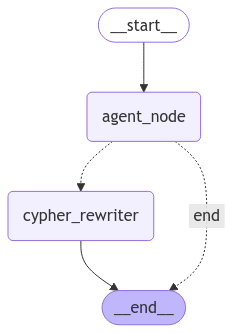

In [302]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [303]:
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage

# Config settings with checkpoint configuration
config = RunnableConfig(
    recursion_limit=10,
    configurable={
        "thread_id": "test_123",
    },
)

initial_state = {
    "messages": [HumanMessage(content="What was the survival rate of first class passengers? Did they have a high mortality rate?")]
}

for chunk in app.stream(initial_state, config, stream_mode="messages"):
    print(chunk)
    print("----")




> Entering new GraphCypherQAChain chain...
(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-1d3b0f4a-d6c5-452c-9b69-4fb69515ef63'), {'thread_id': 'test_123', 'langgraph_step': 1, 'langgraph_node': 'agent_node', 'langgraph_triggers': ['start:agent_node'], 'langgraph_path': ('__pregel_pull', 'agent_node'), 'langgraph_checkpoint_ns': 'agent_node:224b1c76-63a5-bd9b-2769-1831c7fa4a4e', 'checkpoint_ns': 'agent_node:224b1c76-63a5-bd9b-2769-1831c7fa4a4e', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
----
(AIMessageChunk(content='To', additional_kwargs={}, response_metadata={}, id='run-1d3b0f4a-d6c5-452c-9b69-4fb69515ef63'), {'thread_id': 'test_123', 'langgraph_step': 1, 'langgraph_node': 'agent_node', 'langgraph_triggers': ['start:agent_node'], 'langgraph_path': ('__pregel_pull', 'agent_node'), 'langgraph_checkpoint_ns': 'agent_node:224b1c76-63a5-bd9b-2769-1831c7fa4a4e', 'checkpoint_ns': 'agent_node:224b1c

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: 'cypher\nMATCH (p:Passenger {pclass: 1})\nWITH COUNT(p) AS totalFirstClass, \n     COUNT(CASE WHEN p.survived = 1 THEN 1 END) AS survivedFirstClass\nRETURN \n  survivedFirstClass * 1.0 / totalFirstClass AS survivalRate,\n  (totalFirstClass - survivedFirstClass) * 1.0 / totalFirstClass AS mortalityRate\n'


(AIMessageChunk(content=',', additional_kwargs={}, response_metadata={}, id='run-1d3b0f4a-d6c5-452c-9b69-4fb69515ef63'), {'thread_id': 'test_123', 'langgraph_step': 1, 'langgraph_node': 'agent_node', 'langgraph_triggers': ['start:agent_node'], 'langgraph_path': ('__pregel_pull', 'agent_node'), 'langgraph_checkpoint_ns': 'agent_node:224b1c76-63a5-bd9b-2769-1831c7fa4a4e', 'checkpoint_ns': 'agent_node:224b1c76-63a5-bd9b-2769-1831c7fa4a4e', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
----
(AIMessageChunk(content=' then', additional_kwargs={}, response_metadata={}, id='run-1d3b0f4a-d6c5-452c-9b69-4fb69515ef63'), {'thread_id': 'test_123', 'langgraph_step': 1, 'langgraph_node': 'agent_node', 'langgraph_triggers': ['start:agent_node'], 'langgraph_path': ('__pregel_pull', 'agent_node'), 'langgraph_checkpoint_ns': 'agent_node:224b1c76-63a5-bd9b-2769-1831c7fa4a4e', 'checkpoint_ns': 'agent_node:224b1c76-63a5-bd9b-2769-1831c7fa4a4e', 'ls_prov